In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from trsf_datas import physcons
from scipy.interpolate import interp1d
print(physcons.MSUN)

1.9892e+33


## 1. Model Selection ##

In [48]:
path = './trsf_datas/listofmodels.txt'
list_IIL = []
list_Mexc = []
list_IIb = []
list_Mexc_IIb = []
M_H_IIb = []
MODEL = []
MODEL_type = []
MODEL_H = []
MODEL_He = []
MODEL_Mexc = []
data = open(path, 'r')
for i in range(int(1274/2)):
    line1 = np.array(data.readline().split())
    line2 = np.array(data.readline().split())
    H_mass = float(line2[16])
    He_mass = float(line2[17])
    type = line1[2]
    if (0.01<=H_mass) and (H_mass<=0.5) and (type!='0') : 
    #if type == '4':
        MODEL.append(line1[1])
        MODEL_H.append(H_mass)
        MODEL_He.append(He_mass)
        MODEL_Mexc.append(line1[4])
        if type == '2': 
            MODEL_type.append('short_IIP')
        elif type == '3':
            MODEL_type.append('IIb')
        elif type == '4':
            MODEL_type.append('IIL')
        else:
            MODEL_type.append('OTHER')
            
    if int(line1[2]) == 4:
        list_IIL.append(line1[1])
        list_Mexc.append(line1[4])
    #elif int(line1[2]) == 3 and float(line2[16])>0.01:
        #M_H_IIb.append(line2[16])
        #list_IIb.append(line1[1])
        #list_Mexc_IIb.append(line1[4])
    
#print(list_IIL, list_Mexc, '\n'*2, 
########## Check the amount of Hydrogen ########## 
'''for (i,j,k) in zip(list_IIb, list_Mexc_IIb, M_H_IIb):
    print(i, j, k) 
list_MESA = ['Sm11p600', 'Sm11p1000', 'Sm11p1200']'''
for (i,j, k, l) in zip(MODEL, MODEL_type, MODEL_H, MODEL_He):
    print(i,j, "\n Hydrogen mass", k, " Helium mass", l)
print(len(MODEL))

z014-10-0.3-0.6 IIL 
 Hydrogen mass 0.19525  Helium mass 1.44375
z014-10-0.3-2.8 IIb 
 Hydrogen mass 0.01497  Helium mass 0.86381
z014-10-0.4-2.8 IIb 
 Hydrogen mass 0.033  Helium mass 0.86007
z014-10-0.5-2.6 IIb 
 Hydrogen mass 0.0297  Helium mass 0.83042
z014-10-0.5-2.8 IIb 
 Hydrogen mass 0.11583  Helium mass 0.89933
z014-10-0.6-2.6 IIb 
 Hydrogen mass 0.06022  Helium mass 0.85703
z014-10-0.7-2.6 IIb 
 Hydrogen mass 0.10727  Helium mass 0.88378
z014-10-0.8-2.6 IIL 
 Hydrogen mass 0.22866  Helium mass 0.94877
z014-10-0.9-2.6 IIL 
 Hydrogen mass 0.43261  Helium mass 1.05048
z014-12-0.1-0.6 IIL 
 Hydrogen mass 0.09803  Helium mass 1.2411
z014-12-0.4-2.8 IIL 
 Hydrogen mass 0.10756  Helium mass 1.05178
z014-12-0.5-2.8 IIL 
 Hydrogen mass 0.12991  Helium mass 1.06433
z014-12-0.6-2.8 IIL 
 Hydrogen mass 0.17184  Helium mass 1.08616
z014-12-0.9-2.6 IIL 
 Hydrogen mass 0.18081  Helium mass 1.08574
z014-15-0.1-0.6 short_IIP 
 Hydrogen mass 0.30039  Helium mass 1.65554
z014-15-0.4-3 OTHER 
 H

## 2. Converting SNEC ipts to STELLA ipts ##

In [46]:
list_err = []
for (model ,type, H_mass) in zip(MODEL, MODEL_type, MODEL_H):
    
    print(model,'  ',type,'  ',H_mass)
    
    ### Excised mass
    idx = MODEL.index(model)
    M_exc = float(MODEL_Mexc[idx])
    ### Input file path. modify it if needed.
    IO_data = 'D:/20-intern/CURVEPOPS1-release-31-10-18/SNEC-models/DE-input-'+model+'/data'
    IO = 'D:/20-intern/CURVEPOPS1-release-31-10-18/profiles'  
    ### Opt file path
    OPT = './trsf_datas/CURVEPOPS_total_MESA_b4dM4/'
    

    #DATA INTERPOLATION#
    T_data = pd.read_csv(IO+'/input-'+model, header= None, skiprows = 1, sep = '\s+').values #short
    R = pd.read_csv(IO_data+'/rad_initial.dat', header = None, sep = '\s+').values[:,1]
    Rho = pd.read_csv(IO_data+'/rho_initial.dat', header = None, sep = '\s+').values[:,1]
    mass = pd.read_csv(IO_data+'/mass_initial.dat', header = None, sep = '\s+').values[:,1]
    
    ################################# MASS CUT & Nzone settings #################################
    MASK = [(i<T_data[:,2][-1]) and (mass[list(R).index(i)]>(M_exc*physcons.MSUN)*(1+0.015*M_exc)) for i in R]
    R_new = R[MASK]
    Nzone = int(275*(np.log10(R_new[-1])-np.log10(R_new[0]))/4.5)+1
    ### Here, +1 is for the header in .abn files. 
    print('Nzone = ',Nzone)
    
    f_T = interp1d(T_data[:,2], T_data[:,3], kind = 'linear')
    f_Rho = interp1d(R, Rho, kind = 'linear')
    f_mass = interp1d(R, mass, kind = 'linear')

    #NEW DATA GRID#
    step = (np.log10(R_new[-1])-np.log10(R_new[0]))/Nzone
    X_inter = 10**(np.arange(np.log10(R_new[0])+1e-5, np.log10(R_new[-1]), step))
    T_new = f_T(X_inter)
    Rho_new = f_Rho(X_inter)
    mass_new = f_mass(X_inter)
    U_new = np.zeros_like(mass_new)
    
    ##################################### Density smoothing ######################################
    xval = np.log10(X_inter)
    yval = np.log10(Rho_new)
    n_s = 4
    for i in range(len(xval)):
        if i>(5+int(n_s/2)) and i<(len(xval)-int(n_s/2)):
            steep = []
            for j in range(n_s):
                steep.append((yval[i-int(n_s/2)+(j+1)]-yval[i-int(n_s/2)+(j)])/(xval[i-int(n_s/2)+(j+1)]-xval[i-int(n_s/2)+(j)]))
            #threshold = [(abs(k)>3) for k in steep] #Recommended btw 3~4.5
            #print(np.sum(threshold))

            #if np.sum(threshold)>(n_s/2):
            if abs(steep[0]-steep[-1])>1.5:
                for l in range(int(n_s/2)):
                    if l==0:
                        yval[i] = (yval[i-int(n_s/2)]+yval[i+int(n_s/2)])/2
                    else:
                        yval[i-l] = (l*yval[i-int(n_s/2)]+(int(n_s/2)-l)*yval[i])/(int(n_s/2))
                        yval[i+l] = (l*yval[i+int(n_s/2)]+(int(n_s/2)-l)*yval[i])/(int(n_s/2))
            
    ### Reconstruct dm -> dm*(smoothed density/original density)
    dm_new = []
    for i in range(len(X_inter)):
        if i==0:
            dm_new.append((mass_new[0]-mass[0])*(10**(yval[i])/Rho_new[i]))
        else:
            dm_new.append((mass_new[i] - mass_new[i-1])*(10**(yval[i])/Rho_new[i]))
    ### And replace the original density profile to smoothed density profile
    Rho_new = 10**(yval)
        
    ######################### Interpolating element data with .abn/._init ##########################
    elem_data = pd.read_csv(IO+'/input-comp-'+model, header= None, skiprows = 3, sep = '\s+').values #iso.dat
    
    H_frac = interp1d(elem_data[:,1], elem_data[:,2], kind = 'linear')(X_inter)
    He_frac = interp1d(elem_data[:,1], elem_data[:,3], kind = 'linear')(X_inter)
    C_frac = interp1d(elem_data[:,1], elem_data[:,4], kind = 'linear')(X_inter)
    O_frac = interp1d(elem_data[:,1], elem_data[:,6], kind = 'linear')(X_inter)
    Ni_init = pd.read_csv(IO_data+'/Ni_init_frac.dat', header = None, sep = '\s+').values[:,1]
    Ni_frac = interp1d(R,Ni_init, kind = 'cubic')(X_inter)
    
    f_N = interp1d(elem_data[:,1], elem_data[:,5], kind = 'linear')
    N_frac = f_N(X_inter)
    f_Ne = interp1d(elem_data[:,1], elem_data[:,7], kind = 'linear')
    Ne_frac = f_Ne(X_inter)
    f_Mg = interp1d(elem_data[:,1], elem_data[:,8], kind = 'linear')
    Mg_frac = f_Mg(X_inter)
    f_Si = interp1d(elem_data[:,1], elem_data[:,9], kind = 'linear')
    Si_frac = f_Si(X_inter)
    S_frac = np.zeros_like(Si_frac)
    Ar_frac = np.zeros_like(Si_frac)
    Ca_frac = np.zeros_like(Si_frac)
    f_Fe = interp1d(elem_data[:,1], elem_data[:,10], kind = 'linear')
    Fe_frac = f_Fe(X_inter)

    Mstar = float(mass[-1])/physcons.MSUN
    mcut = float(mass_new[0])/physcons.MSUN
    err = (Mstar-mcut-np.sum(dm_new)/physcons.MSUN)/Mstar*100
    list_err.append(err)
    print("total mass = ", Mstar, " mcut = ", mcut," err = ",err,'%')

    ########### OUTPUT ###########
    #HYD
    f = open(OPT+model+'.hyd','w' )
    xhead = '{0:9.1e}{1:4d}{2:13.5e}{3:13.5e}{4:13.4e}\n'.format(0., \
            Nzone-1, mcut, R_new[0], Rho_new[0])
    f.write(xhead)

    Ni_tot = np.dot(dm_new, Ni_frac)/physcons.MSUN
    Ni_tot_corr = np.dot(dm_new, Ni_frac*(0.05/Ni_tot))/physcons.MSUN
    print("total Ni mass = ", Ni_tot, "  corrected Ni mass = ",Ni_tot_corr)
    total_elem_frac = H_frac[50]+He_frac[50]+C_frac[50]+N_frac[50]+O_frac[50]+Ne_frac[50]+\
                       Mg_frac[50]+ Si_frac[50]+S_frac[50]+Ar_frac[50]+Ca_frac[50]+Fe_frac[50]+ Ni_frac[50]
    EL_ = total_elem_frac
    print("Total fraction = ", total_elem_frac)
    INDEX = [i+1 for i in range(Nzone-1)]# 1,2,3,,,,,,,Nzone-1
    for i in INDEX:
        delta = dm_new[i]
        x = ' {0:4d}{1:13.4e}{2:13.4e}{3:13.4e}{4:13.4e}{5:13.4e}{6:20.12e}{7:13.4e}\n'.format(\
         i, delta/physcons.MSUN, X_inter[i], Rho_new[i], T_new[i], U_new[i], mass_new[i]/physcons.MSUN, 0.0)
        f.write(x)
        Ni_tot+=delta*Ni_frac[i]
    f.close()

    #ABN
    f = open(OPT+model+'.abn','w')                                            #
    for i in INDEX:
        x ='{0:4d}{1:11.3e}{2:11.3e}{3:11.3e}{4:11.3e}{5:11.3e}{6:11.3e}{7:11.3e}{8:11.3e}{9:11.3e}{10:11.3e}\
        {11:11.3e}{12:11.3e}{13:11.3e}{14:11.3e}{15:11.3e}{16:11.3e}{17:11.3e}{18:11.3e}{19:11.3e}\n'.\
        format(i, 0.0, 0.0, 0.0, H_frac[i]/EL_, He_frac[i]/EL_, C_frac[i]/EL_, N_frac[i]/EL_, O_frac[i]/EL_, \
               Ne_frac[i]/EL_,0.0, Mg_frac[i]/EL_,0.0, Si_frac[i]/EL_, S_frac[i]/EL_, Ar_frac[i]/EL_, \
               Ca_frac[i]/EL_, Fe_frac[i]/EL_, 0.0, Ni_frac[i]*(0.05/Ni_tot))
        f.write(x)
    f.close()
    print('complete')

z014-10-0.3-0    IIL    5.0694
Nzone =  291
total mass =  11.669352494548523  mcut =  1.4182517476913936  err =  1.1547873091570202 %
total Ni mass =  0.04927451712657712   corrected Ni mass =  0.049999999999999996
Total fraction =  1.0053913980798967
complete
z014-10-0.3-0.6    IIL    0.19525
Nzone =  281
total mass =  4.571751392666823  mcut =  1.415664432003231  err =  0.3607339671597897 %
total Ni mass =  0.049352610602862064   corrected Ni mass =  0.05000000000000002
Total fraction =  1.0170787309643425
complete
z014-10-0.6-2.8    IIL    0.55788
Nzone =  286
total mass =  3.671801802724897  mcut =  1.4068253151032106  err =  0.7647359743758841 %
total Ni mass =  0.0488666110070796   corrected Ni mass =  0.049999999999999996
Total fraction =  1.0241691441649157
complete
z014-10-0.8-2.6    IIL    0.22866
Nzone =  280
total mass =  3.14083169991686  mcut =  1.4010703554310822  err =  0.15909712344785687 %
total Ni mass =  0.04905668724056605   corrected Ni mass =  0.05000000000000001

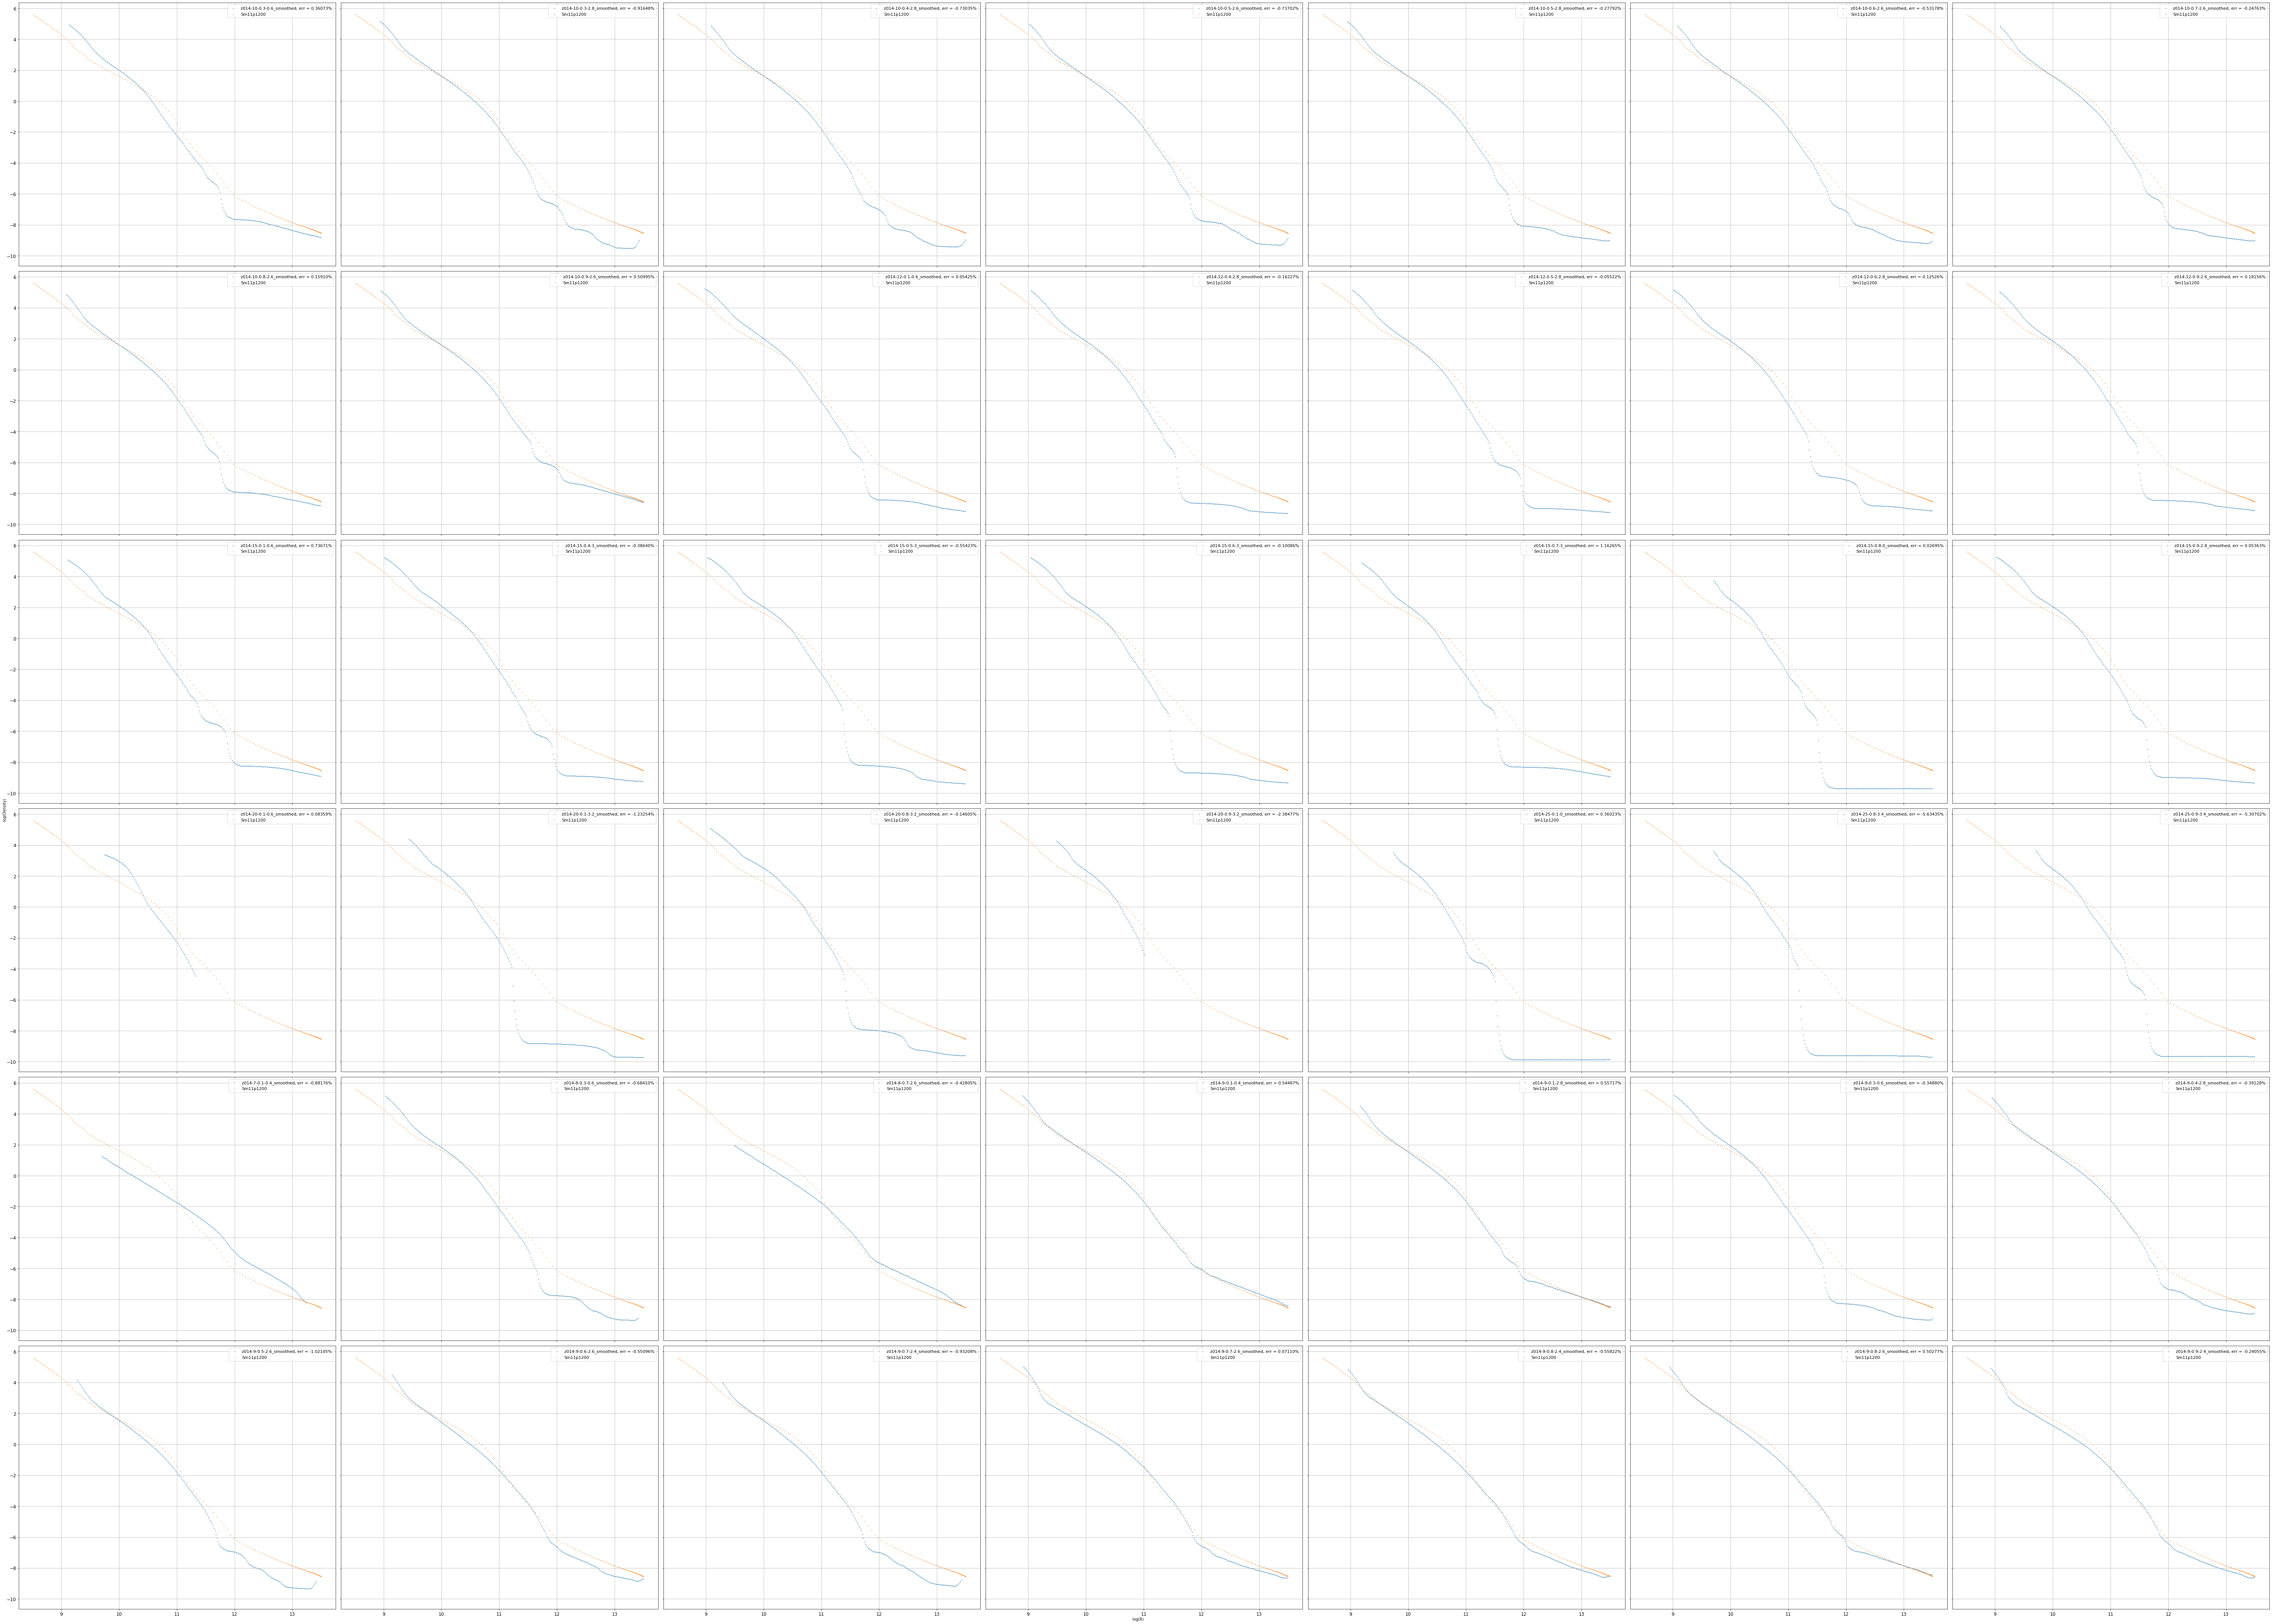

In [40]:
#%matplotlib notebook
#row / column number adjust by manual
fig, axes = plt.subplots(6,7,sharex=True, sharey=True,figsize=(84, 60))
fig.text(0.5, 0, 'log(R)', ha='center')
fig.text(0, 0.5, 'log(Density)', va='center', rotation='vertical')
for (ax, model, err) in zip(axes.flat, MODEL, list_err):
    
    JJ_model = model
    MESA_model = 'Sm11p1200'
    JJ = pd.read_csv(OPT+JJ_model+'.hyd', header = None, skiprows = 1, sep = '\s+').values
    ### Density smoothing ###
    xval = np.log10(JJ[:,2])
    yval = np.log10(JJ[:,3])


    MESA = pd.read_csv('D:/20-intern/comparison/Sm11p1200/Sm11p1200.hyd', header = None, skiprows = 1, sep = '\s+').values
    mask_JJ = [(i>8.5) and (i<13.5) for i in np.log10(JJ[:,2])]
    mask_MESA = [(i>8.5) and (i<13.5) for i in np.log10(MESA[:,2])]

    #plt.scatter(np.log10(JJ[:,2])[mask_JJ], np.log10(JJ[:,3])[mask_JJ], label = JJ_model, s = 2, c = 'g')
    ax.scatter(np.log10(JJ[:,2])[mask_JJ], yval[mask_JJ], label = JJ_model+'_smoothed, err = %.5f'%err+'%', s = 1)
    ax.scatter(np.log10(MESA[:,2])[mask_MESA], np.log10(MESA[:,3])[mask_MESA], label = MESA_model, s = 1)
    '''ax.annotate('stall', xy=(np.log10(JJ[:,2])[mask_JJ][190], np.log10(JJ[:,3])[mask_JJ][190]), xytext=(11, -8), fontsize=10,
                 bbox=dict(boxstyle='square', color='white'), 
                 arrowprops=dict(facecolor='blue', shrink=0.1, width=1)
                )'''
    ax.grid();ax.legend(loc=1, prop={'size': 11} )
    plt.setp(ax.get_xticklabels(),fontsize=12)
    plt.setp(ax.get_yticklabels(),fontsize=12)
    plt.tight_layout()
plt.show()

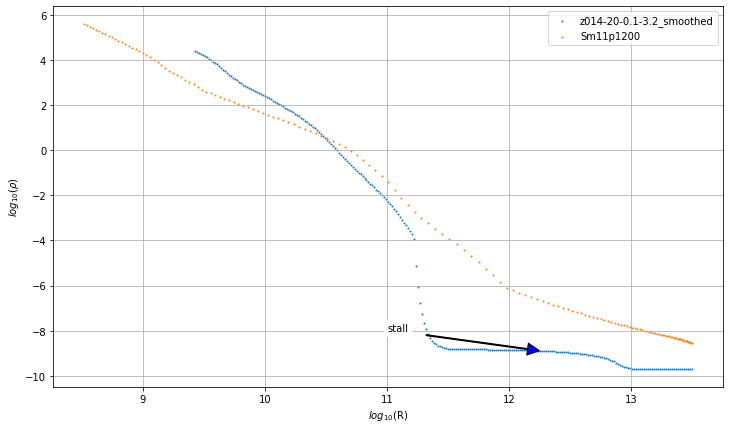

In [48]:
plt.rcParams['figure.figsize'] = (12,7)
JJ_model = 'z014-20-0.1-3.2'
MESA_model = 'Sm11p1200'
JJ = pd.read_csv(OPT+JJ_model+'.hyd', header = None, skiprows = 1, sep = '\s+').values
### Density smoothing ###
xval = np.log10(JJ[:,2])
yval = np.log10(JJ[:,3])


MESA = pd.read_csv('D:/20-intern/comparison/Sm11p1200/Sm11p1200.hyd', header = None, skiprows = 1, sep = '\s+').values
mask_JJ = [(i>8.5) and (i<13.5) for i in np.log10(JJ[:,2])]
mask_MESA = [(i>8.5) and (i<13.5) for i in np.log10(MESA[:,2])]

#plt.scatter(np.log10(JJ[:,2])[mask_JJ], np.log10(JJ[:,3])[mask_JJ], label = JJ_model, s = 2, c = 'g')
plt.scatter(np.log10(JJ[:,2])[mask_JJ], yval[mask_JJ], label = JJ_model+'_smoothed', s = 1)
plt.scatter(np.log10(MESA[:,2])[mask_MESA], np.log10(MESA[:,3])[mask_MESA], label = MESA_model, s = 1)
plt.annotate('stall', xy=(np.log10(JJ[:,2])[mask_JJ][180], np.log10(JJ[:,3])[mask_JJ][189]), xytext=(11, -8), fontsize=10,
             bbox=dict(boxstyle='square', color='white'), 
             arrowprops=dict(facecolor='blue', shrink=0.1, width=1)
            )
plt.xlabel(r'$log_{10}$(R)');plt.ylabel(r'$log_{10}(\rho)$')
plt.grid()
plt.legend()
plt.show()

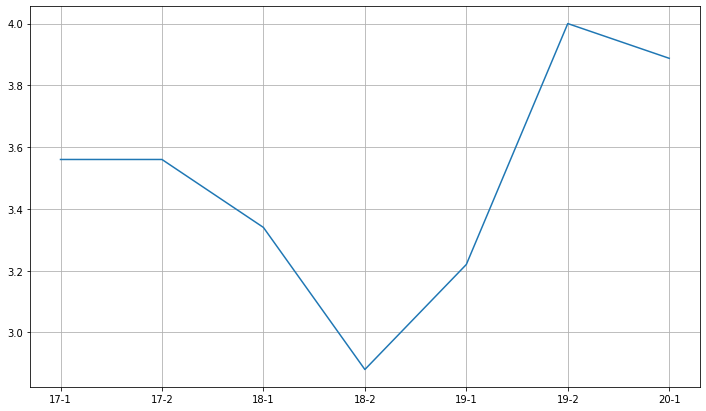

In [80]:
sem = ['17-1','17-2','18-1','18-2','19-1','19-2','20-1']
sco = [3.56,3.56,3.34,2.88,3.22,4,3.8875]
plt.grid()
plt.annotate()
plt.plot(sem,sco)